# Perplexity Detector Analysis

This notebook benchmarks and visualizes the frozen-LM perplexity detector on RAID. It scores the held-out split, inspects distributions, spots mismatches, and dives into token-level behavior to explain what the zero-shot classifier is doing.

In [64]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
PROJECT_ROOT

PosixPath('/home/erikhbj/Documents/tdt13/TDT13_AI_text_prediction')

In [65]:
import math
from pathlib import Path
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from sklearn.calibration import calibration_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split

from raid.utils import load_data

from src import config
from src import data as data_module
from src.models.perplexity_detector import PerplexityDetector
from src.models.perplexity_classifier import PerplexityLogisticClassifier


In [66]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

## Configuration

In [67]:
DATA_LIMIT = None # 8000  # use None for the full RAID split
SAMPLE_SEED = 42
TEST_RATIO = 0.02 # 0.2
INCLUDE_ADVERSARIAL = config.DEFAULT_INCLUDE_ADVERSARIAL

PPL_MODEL = "meta-llama/Llama-3.2-1B"
PPL_BATCH_SIZE = 8
PPL_MAX_LENGTH = 768
PPL_THRESHOLD = None  # Optional manual NLL boundary
SHOW_PROGRESS = True

np.random.seed(SAMPLE_SEED)
PPL_CLASSIFIER_PATH = Path("../models/perplexity-logistic/perplexity_classifier.pkl")


## Load and prepare the RAID split

In [68]:
raw_df = load_data(split="train", include_adversarial=INCLUDE_ADVERSARIAL)
if DATA_LIMIT is not None:
    if DATA_LIMIT <= 0:
        raise ValueError("DATA_LIMIT must be positive or None.")
    raw_df = raw_df.sample(n=min(DATA_LIMIT, len(raw_df)), random_state=SAMPLE_SEED).reset_index(drop=True)

raw_texts = raw_df[data_module.TEXT_SOURCE_COLUMN]
labels = data_module._extract_labels(raw_df)  # type: ignore[attr-defined]
valid_mask = raw_texts.notna()
filtered = raw_df.loc[valid_mask].copy()
filtered["text"] = raw_texts.loc[valid_mask].astype(str)
filtered["label"] = labels.loc[valid_mask].astype(int)

train_df, test_df = train_test_split(
    filtered,
    test_size=TEST_RATIO,
    random_state=SAMPLE_SEED,
    stratify=filtered["label"],
)
analysis_df = test_df.reset_index(drop=True).copy()
analysis_df["label_name"] = analysis_df["label"].map({0: "Human", 1: "AI"})
analysis_df["char_len"] = analysis_df["text"].str.len()
print(f"Train size: {len(train_df):,} | Test size: {len(analysis_df):,}")
print("Available metadata columns:", [c for c in analysis_df.columns if c not in {"text", "label", "label_name"}])

Train size: 458,625 | Test size: 9,360
Available metadata columns: ['id', 'adv_source_id', 'source_id', 'model', 'decoding', 'repetition_penalty', 'attack', 'domain', 'title', 'prompt', 'generation', 'char_len']


## Score the split with the frozen LM

In [69]:
perplexity_classifier = PerplexityLogisticClassifier.load(PPL_CLASSIFIER_PATH)
detector = perplexity_classifier.detector


In [70]:
texts = analysis_df["text"].tolist()
preds, probs, mean_logp, nll, std_logp = perplexity_classifier.predict(texts, return_nnl_features=True)

analysis_df["nll"] = nll
analysis_df["mean_logp"] = mean_logp
analysis_df["std_logp"] = std_logp
analysis_df["score"] = probs
analysis_df["pred"] = preds
analysis_df["pred_name"] = analysis_df["pred"].map({0: "Human", 1: "AI"})
analysis_df["error_type"] = np.where(
    analysis_df["pred"] == analysis_df["label"],
    "Correct",
    np.where(analysis_df["pred"] == 1, "False Positive", "False Negative"),
)
lengths = detector.tokenizer(
    texts,
    truncation=True,
    max_length=PPL_MAX_LENGTH,
    return_length=True,
)
analysis_df["token_count"] = lengths["length"]
analysis_df.replace({np.inf: np.nan, -np.inf: np.nan}, inplace=True)

def compute_surface_features(text: str) -> tuple[float, float, float]:
    tokens = [tok for tok in text.split() if tok.strip()]
    if not tokens:
        return 0.0, 0.0, 0.0
    avg_len = float(np.mean([len(tok) for tok in tokens]))
    unique = len({tok.lower() for tok in tokens})
    ttr = unique / len(tokens)
    digit_ratio = sum(tok.isdigit() for tok in tokens) / len(tokens)
    return avg_len, ttr, digit_ratio

surface = analysis_df["text"].apply(compute_surface_features)
analysis_df[["avg_word_len", "unique_token_ratio", "digit_ratio"]] = pd.DataFrame(surface.tolist(), index=analysis_df.index)
analysis_df.head()


/home/erikhbj/Documents/tdt13/TDT13_AI_text_prediction/.venv/lib/python3.11/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,...,mean_logp,std_logp,score,pred,pred_name,error_type,token_count,avg_word_len,unique_token_ratio,digit_ratio
0,2df8825a-2356-4b55-8ded-b246c31a5c92,2df8825a-2356-4b55-8ded-b246c31a5c92,4a9beaa2-84f5-498b-92d9-935107c550b0,chatgpt,greedy,no,none,books,Personal Injuries,Write the body of a plot summary for a novel t...,...,-1.551758,1.953125,0.701587,1,AI,Correct,262,5.079070,0.674419,0.000000
1,56ddff7a-532b-4c56-858f-cd4a27b62695,56ddff7a-532b-4c56-858f-cd4a27b62695,25fef5f2-90c7-4f9c-9cfb-6caff6c69359,llama-chat,greedy,no,none,reddit,WMR constantly goes into sleep mode even when ...,"Write just the body of a Reddit post titled ""W...",...,-1.721680,1.864258,0.837293,1,AI,Correct,144,4.868421,0.745614,0.000000
2,762ecae0-9a0e-4207-a217-01da39451e60,762ecae0-9a0e-4207-a217-01da39451e60,ff71deab-4af9-4712-9a32-c46477997857,mpt,sampling,yes,none,poetry,Rudyard Kipling Parody Writers Real Mirror Ref...,The following is the full text of a poem title...,...,-4.359375,2.435547,0.926511,1,AI,Correct,461,5.888041,0.974555,0.000000
3,0bdf2ff9-b0c8-447b-8177-d1a686dc3782,0bdf2ff9-b0c8-447b-8177-d1a686dc3782,87fb4135-4456-4276-bfdc-05ee75825a27,gpt2,sampling,no,none,books,Arundhati,The following is the full text of a plot summa...,...,-2.416016,2.279297,0.585637,1,AI,Correct,463,4.767045,0.590909,0.002841
4,e47640bf-74e4-4c7a-8071-fd8012da79c8,e47640bf-74e4-4c7a-8071-fd8012da79c8,c568b816-b63e-4969-9a57-99d4c072e0b6,mistral,greedy,no,none,abstracts,WAYLA - Generating Images from Eye Movements,The following is the full text of the abstract...,...,-0.577637,1.404297,0.922349,1,AI,Correct,440,4.725067,0.183288,0.000000


### Aggregate performance snapshot

In [71]:
report = classification_report(analysis_df["label"], analysis_df["pred"], output_dict=True)
report_df = pd.DataFrame(report).T
print("Perplexity detector metrics:")
display(report_df[["precision", "recall", "f1-score"]])
print("NLL summary (lower = more AI-like):")
display(analysis_df["nll"].describe(percentiles=[0.1, 0.5, 0.9]))

Perplexity detector metrics:


,precision,recall,f1-score
0,0.099132,0.812734,0.176710
1,0.993027,0.783130,0.875676
accuracy,0.783974,0.783974,0.783974
macro avg,0.546080,0.797932,0.526193
weighted avg,0.967529,0.783974,0.855738


NLL summary (lower = more AI-like):


count    9360.000000
mean        1.981363
std         0.976502
min         0.056274
10%         0.847070
50%         1.844727
90%         3.330078
max        10.179688
Name: nll, dtype: float64

## 1. Score distributions over classes

In [72]:
analysis_df.columns

Index(['id', 'adv_source_id', 'source_id', 'model', 'decoding',
       'repetition_penalty', 'attack', 'domain', 'title', 'prompt',
       'generation', 'text', 'label', 'label_name', 'char_len', 'nll',
       'mean_logp', 'std_logp', 'score', 'pred', 'pred_name', 'error_type',
       'token_count', 'avg_word_len', 'unique_token_ratio', 'digit_ratio'],
      dtype='object')

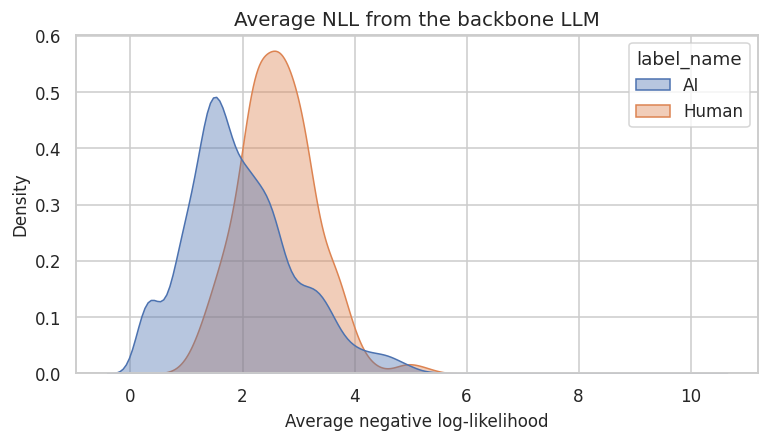

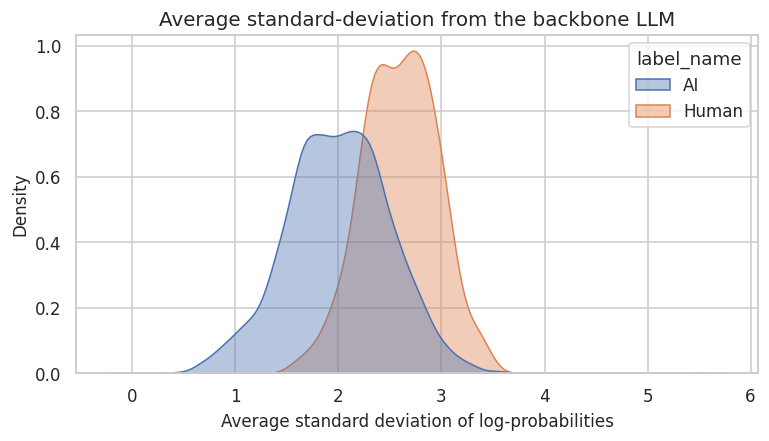

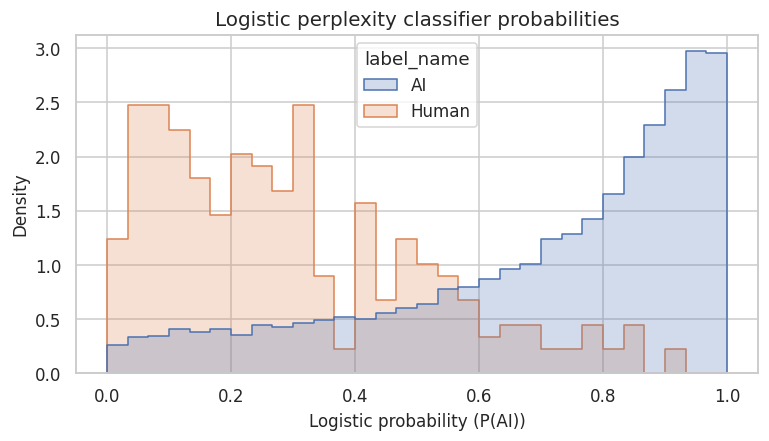

In [73]:
finite = analysis_df[np.isfinite(analysis_df[["nll", "std_logp"]]).all(axis=1)]
plt.figure(figsize=(8, 4))
sns.kdeplot(data=finite, x="nll", hue="label_name", fill=True, common_norm=False, alpha=0.4)
plt.title("Average NLL from the backbone LLM")
plt.xlabel("Average negative log-likelihood")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(8, 4))
sns.kdeplot(data=finite, x="std_logp", hue="label_name", fill=True, common_norm=False, alpha=0.4)
plt.title("Average standard-deviation from the backbone LLM")
plt.xlabel("Average standard deviation of log-probabilities")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data=finite, x="score", hue="label_name", bins=30, element="step", stat="density", common_norm=False)
plt.title("Logistic perplexity classifier probabilities")
plt.xlabel("Logistic probability (P(AI))")
plt.show()

## 2. Domain / generator diagnostics

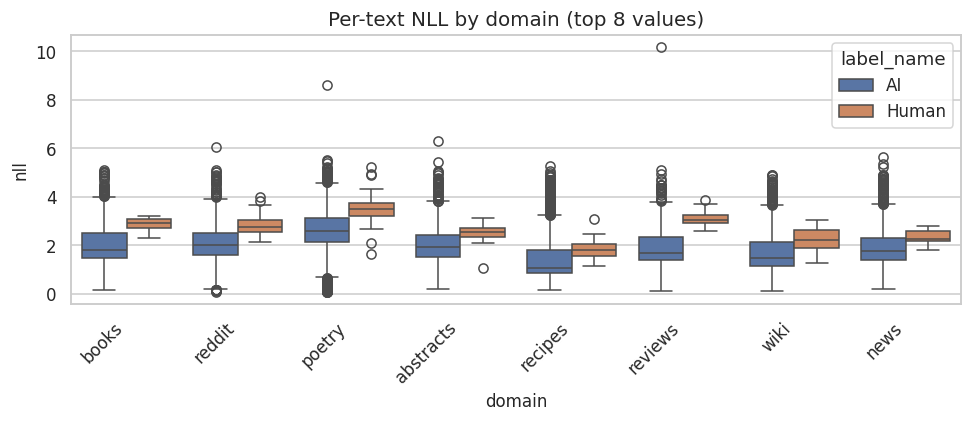

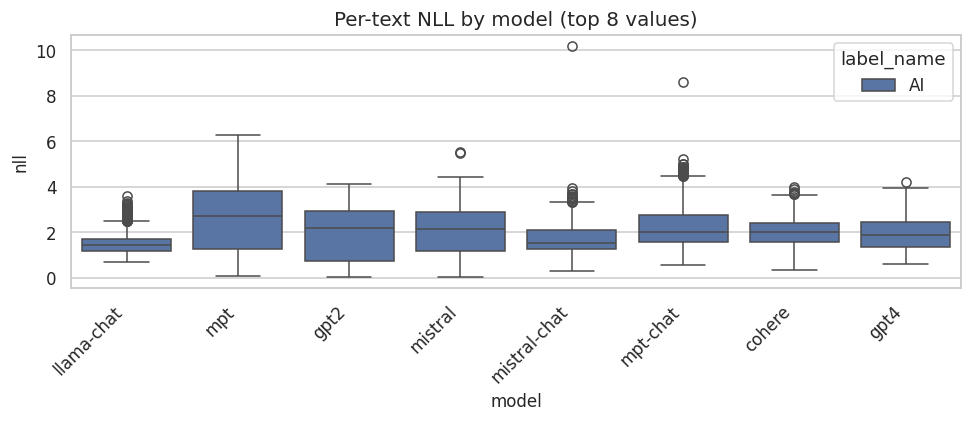

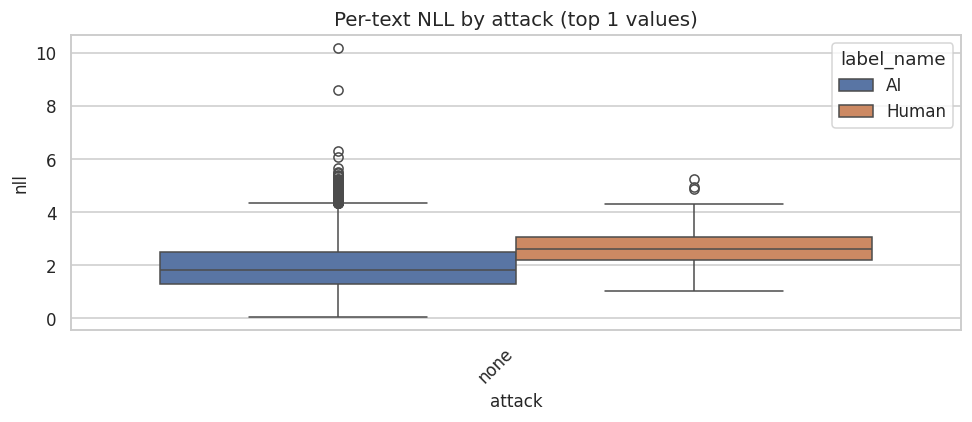

In [74]:
meta_candidates = ["domain", "model", "generator", "attack", "source_dataset", "decoder"]
available_meta = [col for col in meta_candidates if col in analysis_df.columns]
if not available_meta:
    print("No metadata columns available in this split; skip domain diagnostics.")
else:
    for col in available_meta:
        subset = analysis_df.copy()
        subset[col] = subset[col].fillna("unknown")
        top_values = subset[col].value_counts().head(8).index
        plot_df = subset[subset[col].isin(top_values)]
        plt.figure(figsize=(9, 4))
        sns.boxplot(data=plot_df, x=col, y="nll", hue="label_name")
        plt.title(f"Per-text NLL by {col} (top {len(top_values)} values)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

## 3. Length and fluency effects

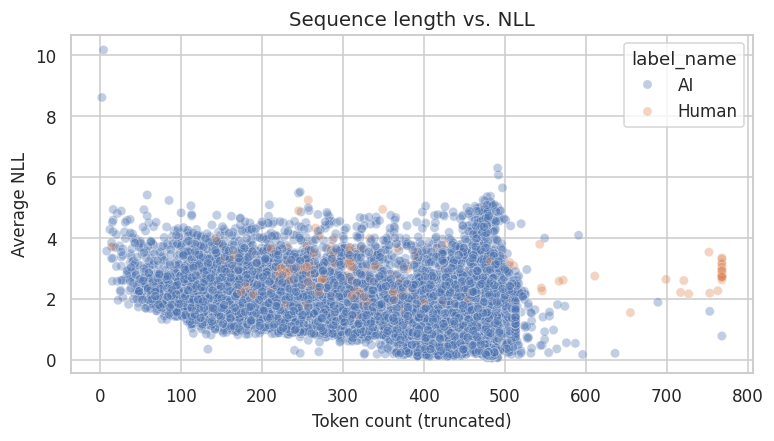

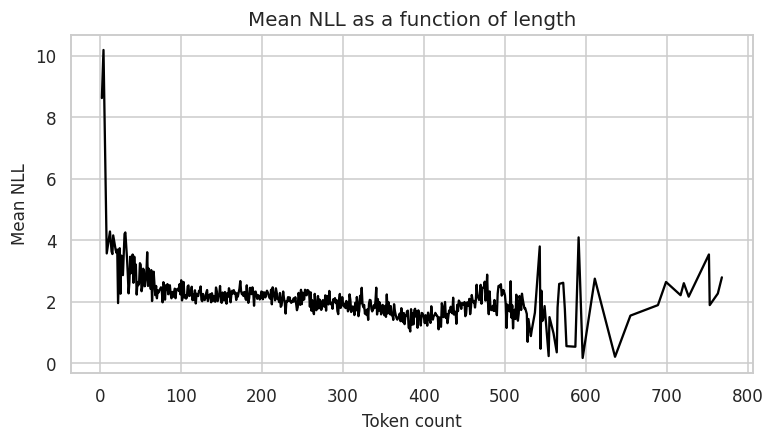

In [75]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=analysis_df, x="token_count", y="nll", hue="label_name", alpha=0.35)
plt.title("Sequence length vs. NLL")
plt.xlabel("Token count (truncated)")
plt.ylabel("Average NLL")
plt.show()

plt.figure(figsize=(8, 4))
mean_curve = analysis_df.groupby("token_count")["nll"].mean().reset_index()
sns.lineplot(data=mean_curve, x="token_count", y="nll", color="black")
plt.title("Mean NLL as a function of length")
plt.xlabel("Token count")
plt.ylabel("Mean NLL")
plt.show()

## 4. Burstiness vs. average surprise

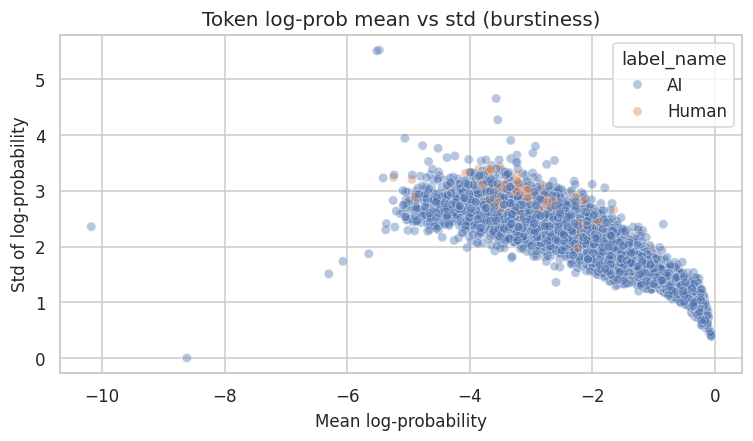

In [76]:
burst_df = analysis_df[np.isfinite(analysis_df["mean_logp"]) & np.isfinite(analysis_df["std_logp"])]
plt.figure(figsize=(8, 4))
sns.scatterplot(data=burst_df, x="mean_logp", y="std_logp", hue="label_name", alpha=0.4)
plt.title("Token log-prob mean vs std (burstiness)")
plt.xlabel("Mean log-probability")
plt.ylabel("Std of log-probability")
plt.show()

## 5. Calibration-style reliability

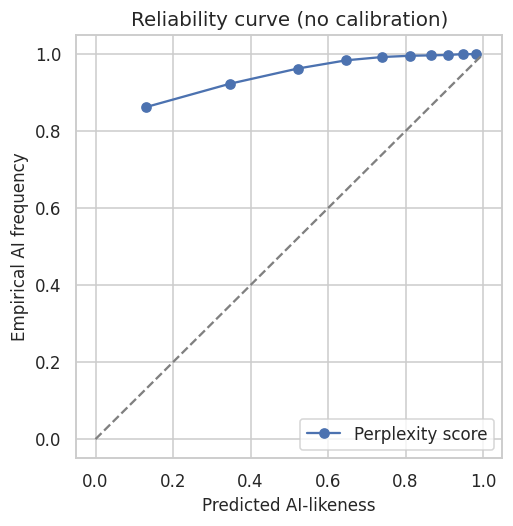

In [77]:
prob_true, prob_pred = calibration_curve(analysis_df["label"], analysis_df["score"], n_bins=10, strategy="quantile")
plt.figure(figsize=(5, 5))
plt.plot(prob_pred, prob_true, marker="o", label="Perplexity score")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Predicted AI-likeness")
plt.ylabel("Empirical AI frequency")
plt.title("Reliability curve (no calibration)")
plt.legend()
plt.show()

## 6. Error forensics

In [78]:
errors = analysis_df[analysis_df["error_type"] != "Correct"].copy()
print(f"Total errors: {len(errors)} ({len(errors)/len(analysis_df):.1%})")
if errors.empty:
    print("No misclassifications on this split.")
else:
    cols = ["label_name", "pred_name", "score", "nll", "token_count"]
    if "domain" in errors.columns:
        cols.append("domain")
    display(errors[cols].head(10))
    sample = errors.sort_values("score", ascending=False).iloc[0]
    print("Highest-confidence error snippet:")
    print(f"Label={sample['label_name']}, Pred={sample['pred_name']}, Score={sample['score']:.3f}, Tokens={sample['token_count']}")
    wrapped = textwrap.fill(sample["text"], width=100)
    print(wrapped)

Total errors: 2022 (21.6%)


,label_name,pred_name,score,nll,token_count,domain
8,AI,Human,0.454734,3.105469,460,wiki
14,AI,Human,0.077486,2.910156,34,poetry
19,AI,Human,0.256784,4.324219,364,recipes
20,AI,Human,0.335191,1.434570,275,recipes
24,AI,Human,0.309869,3.439453,174,abstracts
25,Human,AI,0.547520,2.318359,341,news
26,AI,Human,0.092907,2.744141,37,recipes
29,AI,Human,0.248612,2.992188,99,news
41,AI,Human,0.450818,2.287109,232,poetry
51,AI,Human,0.457367,2.601562,150,news


Highest-confidence error snippet:
Label=Human, Pred=AI, Score=0.923, Tokens=320
2 1/4 cups all purpose flour 2 tablespoons granulated sugar 1/2 cup butter cold, chopped 1 egg yolk
1 tablespoon lemon juice 2 cups milk 1/2 teaspoon vanilla bean paste 4 egg yolks 1/2 cup granulated
sugar 2 tablespoons cornstarch 1 tablespoon all-purpose flour fruit seasonal, to decorate Preheat
oven to 400°F. Lightly grease a 9 inch loose-bottom tart pan. Sift flour into a large bowl. Add
sugar. Cut in butter until mixture resembles breadcrumbs. Add 1/4 cup water, egg yolk and lemon
juice. Mix until smooth then knead lightly. Wrap in plastic wrap and chill for 30 mins. Roll dough
out until 1/8 inch thick and use to line pan. Trim edges. Chill for 10 mins. Reduce heat to 350°F.
Line tart shell with parchment paper and pie weights. Blind bake for 10-15 mins. Remove paper and
weights and bake for another 10-15 mins, until golden brown. Meanwhile, for the filling, bring milk
and vanilla bean paste to a boil. 

## 7. Token-level log-prob trajectories

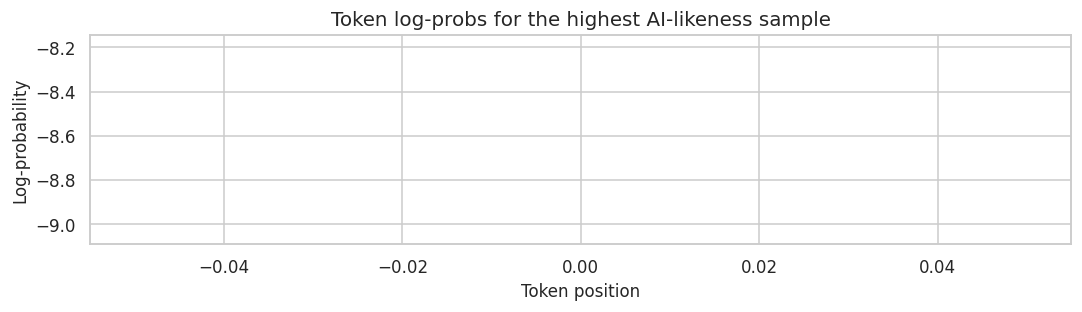

,token,logp
0,âĢĭ,-8.617188


In [79]:

def token_logprob_trace(detector: PerplexityDetector, text: str):
    encoded = detector.tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=detector.max_length,
    )
    input_ids = encoded["input_ids"].to(detector._device)  # pylint: disable=protected-access
    attention_mask = encoded["attention_mask"].to(detector._device)
    labels = input_ids.clone()
    labels[attention_mask == 0] = -100
    with torch.no_grad():
        outputs = detector.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits[:, :-1, :]
        shift_labels = labels[:, 1:]
        valid_mask = shift_labels != -100
        log_probs = torch.log_softmax(logits, dim=-1)
        gathered = log_probs.gather(-1, shift_labels.unsqueeze(-1)).squeeze(-1)
        gathered = torch.where(valid_mask, gathered, torch.zeros_like(gathered))
    seq_logp = gathered[0, valid_mask[0]].cpu().numpy()
    token_ids = input_ids[0, 1 : 1 + len(seq_logp)].cpu().tolist()
    tokens = detector.tokenizer.convert_ids_to_tokens(token_ids)
    return pd.DataFrame({"token": tokens, "logp": seq_logp})

sample_idx = analysis_df["score"].idxmax()
trace_df = token_logprob_trace(detector, analysis_df.loc[sample_idx, "text"])
plt.figure(figsize=(10, 3))
plt.plot(trace_df["logp"])
plt.title("Token log-probs for the highest AI-likeness sample")
plt.xlabel("Token position")
plt.ylabel("Log-probability")
plt.tight_layout()
plt.show()
trace_df.head(20)

## 8. Threshold sweeps (ROC & PR curves)

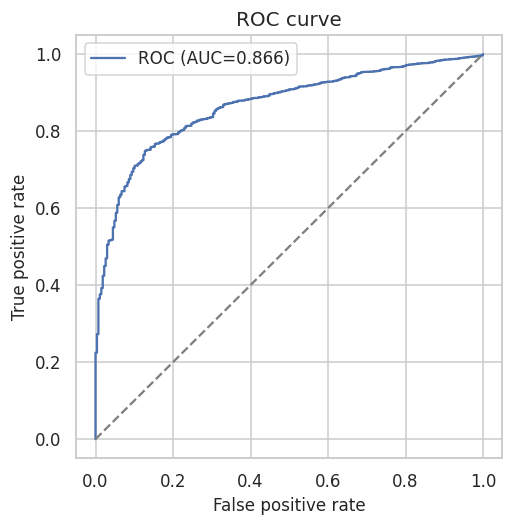

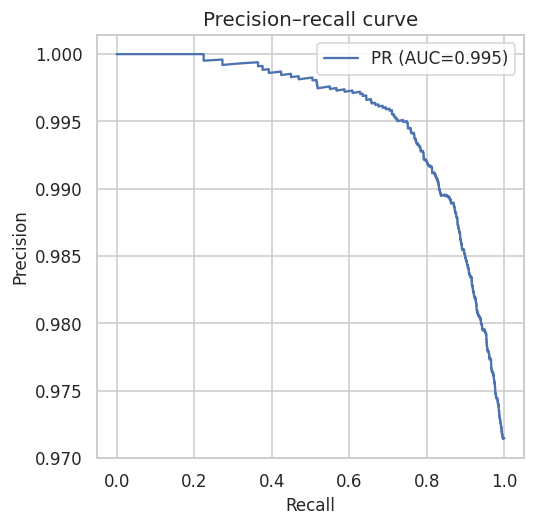

In [80]:
fpr, tpr, _ = roc_curve(analysis_df["label"], analysis_df["score"])
precision, recall, _ = precision_recall_curve(analysis_df["label"], analysis_df["score"])
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(recall, precision, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–recall curve")
plt.legend()
plt.show()

## 9. Domain transfer heatmap

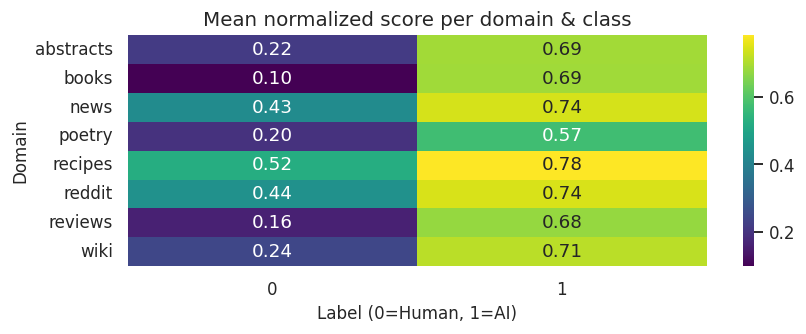

In [81]:
if "domain" not in analysis_df.columns:
    print("Domain column unavailable; skipping heatmap.")
else:
    domain_stats = (
        analysis_df.groupby(["domain", "label"])["score"]
        .mean()
        .rename("mean_score")
        .reset_index()
    )
    pivot = domain_stats.pivot(index="domain", columns="label", values="mean_score")
    plt.figure(figsize=(8, max(3, 0.4 * len(pivot))))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
    plt.title("Mean normalized score per domain & class")
    plt.xlabel("Label (0=Human, 1=AI)")
    plt.ylabel("Domain")
    plt.tight_layout()
    plt.show()

In [82]:
analysis_df.groupby(["domain", "label"])["id"].count()

domain     label
abstracts  0          36
           1        1232
books      0          29
           1        1223
news       0          35
           1        1223
poetry     0          42
           1        1171
recipes    0          40
           1        1227
reddit     0          30
           1        1165
reviews    0          22
           1         626
wiki       0          33
           1        1226
Name: id, dtype: int64

## 10. Residual feature analysis

In [83]:
analysis_df[["id", "mean_logp", "unique_token_ratio", "pred", "score", "label"]]

,id,mean_logp,unique_token_ratio,pred,score,label
0,2df8825a-2356-4b55-8ded-b246c31a5c92,-1.551758,0.674419,1,0.701587,1
1,56ddff7a-532b-4c56-858f-cd4a27b62695,-1.721680,0.745614,1,0.837293,1
2,762ecae0-9a0e-4207-a217-01da39451e60,-4.359375,0.974555,1,0.926511,1
3,0bdf2ff9-b0c8-447b-8177-d1a686dc3782,-2.416016,0.590909,1,0.585637,1
4,e47640bf-74e4-4c7a-8071-fd8012da79c8,-0.577637,0.183288,1,0.922349,1
...,...,...,...,...,...,...
9355,306b52a2-fbbc-4b39-adce-66a292a30a60,-1.320312,0.616099,1,0.688108,1
9356,0ef23c20-b13d-4667-967e-923323c5ce25,-2.398438,0.865546,0,0.480832,1
9357,653ea0db-8a6b-4c6a-882f-3f4b32d19d52,-2.525391,0.643939,0,0.222584,1
9358,802e7b6b-1f9b-4ada-adf8-6080af376a26,-1.049805,0.683230,1,0.845942,1


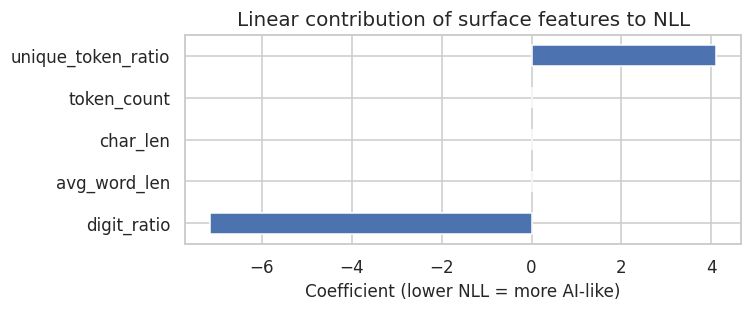

char_len              0.000021
token_count           0.001384
avg_word_len         -0.000135
unique_token_ratio    4.106472
digit_ratio          -7.149201
dtype: float64

In [84]:
feature_cols = ["char_len", "token_count", "avg_word_len", "unique_token_ratio", "digit_ratio"]
feature_df = analysis_df[feature_cols].fillna(0.0)
model = LinearRegression().fit(feature_df, analysis_df["nll"])
coef = pd.Series(model.coef_, index=feature_cols)
plt.figure(figsize=(7, 3))
coef.sort_values().plot(kind="barh")
plt.title("Linear contribution of surface features to NLL")
plt.xlabel("Coefficient (lower NLL = more AI-like)")
plt.tight_layout()
plt.show()
coef

## 11. Logistic regression head on perplexity features

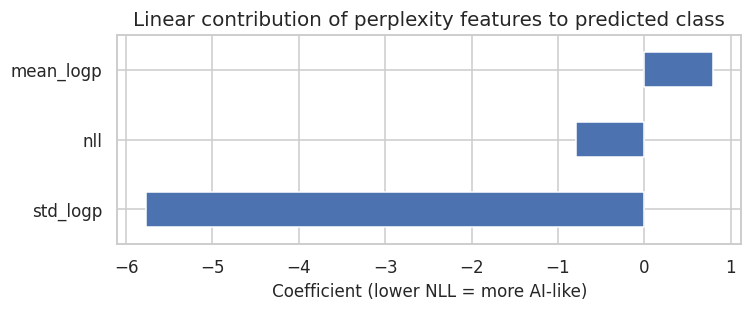

mean_logp    0.795152
nll         -0.795152
std_logp    -5.774080
dtype: float64

In [85]:
feature_cols = ["mean_logp", "nll", "std_logp"] # ["char_len", "token_count", "avg_word_len", "unique_token_ratio", "digit_ratio"]
feature_df = analysis_df[feature_cols].fillna(0.0)
model = perplexity_classifier.logistic_model
coef = pd.Series(model.coef_[0], index=feature_cols)
plt.figure(figsize=(7, 3))
coef.sort_values().plot(kind="barh")
plt.title("Linear contribution of perplexity features to predicted class")
plt.xlabel("Coefficient (lower NLL = more AI-like)")
plt.tight_layout()
plt.show()
coef